In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# What are the two most important features of our data?
- We will use season average ratios as input to different regression models which predict games won in a season. 
- After getting a good prediction with all of the ratios, we will use recursive feature elimination (RFE) to find the two most important features.
- Interesting conclusions will be what the two chosen features are and if they differ between different models.

## First we load in the data and get the ratio stats:

In [3]:
# Read in the average season stats data
df = pd.read_csv("./seasonStats.csv")

# Get only the entries with useful data
df = df.loc[df["AVGFGA3"] > 0.0]

# All of the stats we have data for
statsToMeasure = ["Score", "FGM", "FGA", "FGM3", "FGA3", "FTM", "FTA", "OR", "DR", "Ast", "TO", "Stl", "Blk", "PF"]

# All of the average stats
averageStats = ["AVG" + stat for stat in statsToMeasure]

# All of opponent average stats
oAverageStats = ["O" + stat for stat in averageStats]

# All of the ratio stats
ratStats = ["RAT" + stat for stat in statsToMeasure]

seasonRatDat = df.loc[:, ratStats]
seasonWinDat = df.loc[:, "GamesWon"]

## Now we train our linear models:

In [4]:
# Import the models we want
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

# Create instances of the models for training
models = [
    LinearRegression(),
    LassoCV(),
    RidgeCV(),
    ElasticNetCV()
]

# Keep track of model names for later use
modelNames = [
    "LinearRegression",
    "Lasso",
    "Ridge",
    "ElasticNet"
]

# Train the models
for model in models:
    model.fit(seasonRatDat, seasonWinDat)

## Let's see which one performed the best:

In [5]:
# Import RMSE
from sklearn.metrics import mean_squared_error

# Create an array to hold RMSE errors
errors = np.zeros(len(models))

# Calculate the RMSE of each model
for i, model in enumerate(models):
    winPrediction = model.predict(seasonRatDat)
    errors[i] = mean_squared_error(y_true = seasonWinDat,
                                   y_pred= winPrediction,
                                   squared=False)
print(errors)

[2.27086342 2.27213802 2.27185974 2.30718973]


- All of the models performed similarly, but plain linear regression does have the lowest error.
- Right behind it is ridge regression.
- These different models have other pros and cons besides just errors. For example, the models besides plain linear regression try and 0 out as many coefficients as possible.

# Here is a plot of the win predictions of these models for a single team (Duke):

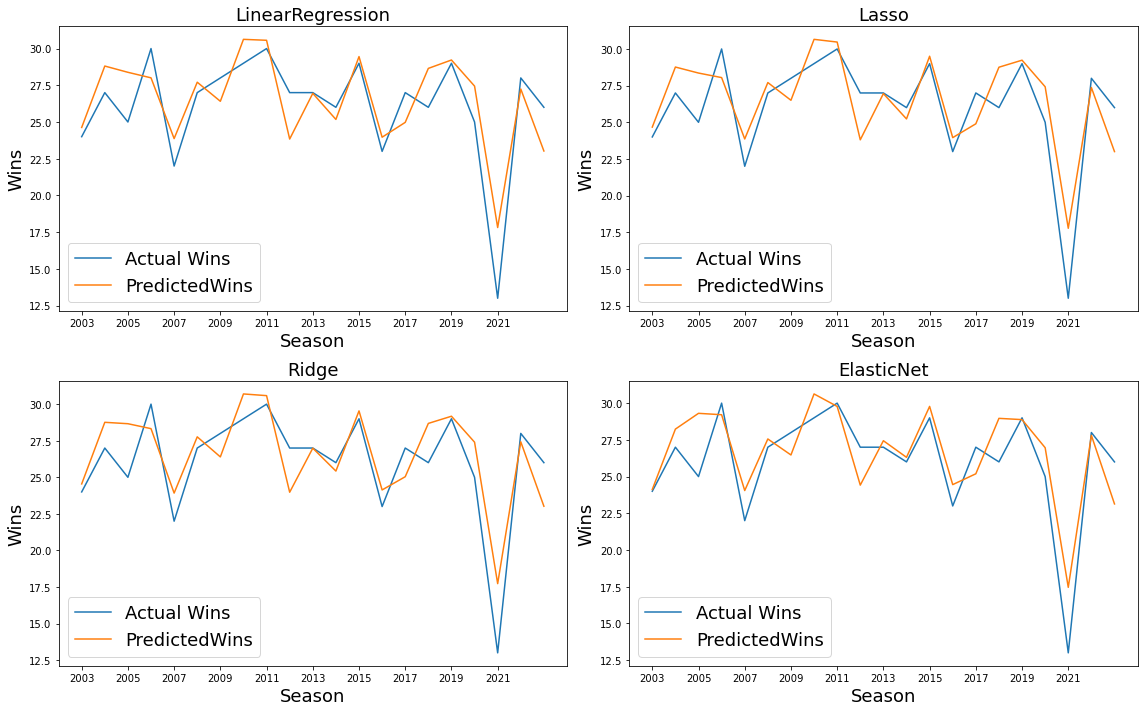

In [18]:
# Import team names data
teamNames = pd.read_csv("./data/MTeams.csv")

# Get Duke's identifying ID
teamID = teamNames.loc[teamNames["TeamName"] == "Duke", "TeamID"].item()

# Get seasons for x-axis
seasons = df["Season"].unique()

# Get Duke rat stats
teamRat = df.loc[df["TeamID"] == teamID, ratStats]

# Get Duke's actual wins
actualWins = df.loc[df["TeamID"] == teamID, "GamesWon"]

# Make a matrix to store predicted wins
predictedWins = np.zeros((len(models), len(actualWins)))

# Get predicted wins for each model
for i, model in enumerate(models):
    predictedWins[i,:] = model.predict(teamRat)

# Plot these predictions
fig, axs = plt.subplots(nrows = 2,
                        ncols= 2,
                        figsize = (16, 10)
                       )

for i, (modelName, ax) in enumerate(zip(modelNames, axs.flatten())):
    ax.plot(seasons, actualWins)
    ax.plot(seasons, predictedWins[i,:])

    
    ax.set_title(modelName, size= 18)
    ax.set_xlabel("Season", size = 18)
    ax.set_ylabel("Wins", size = 18)
    ax.set_xticks(range(2003, 2023, 2))
    ax.legend(["Actual Wins", "PredictedWins"], fontsize=18)

plt.tight_layout()

plt.savefig("./plots/regressionDukeAll.png")
plt.show()

- We now have working models, but the coefficients are slightly hard to interpret
- For example, here are the coefficients for ridge:

In [7]:
# Print ridge coefficients
for stat, coeff in zip(ratStats, models[2].coef_):
    print(f"{stat} : {coeff}")

RATScore : 41.18437911196856
RATFGM : 5.1282597291986205
RATFGA : -7.851227387816081
RATFGM3 : 2.129197502616195
RATFGA3 : -0.8829173007261485
RATFTM : 2.0468512608376233
RATFTA : 0.7979404653191424
RATOR : 0.931157860514258
RATDR : 5.287220443312434
RATAst : -0.2525295131989716
RATTO : -5.087912918012726
RATStl : 0.37732852954441176
RATBlk : 0.3274990578102271
RATPF : -0.18432514026984154


- It's also pretty obvious. Of course teamScore/oppScore = RATScore is going to predict wins most effectively
- Now we will use RFE to try and find the key features for each of these models

In [8]:
# Import the sklearn RFE implementation
from sklearn.feature_selection import RFE

# Create a list of models with RFE
RFEModels = [
    RFE(estimator=model,
                   n_features_to_select=2,
                   step=1
                  )
    for model in models
]

# Fit all of the models
for model in RFEModels:
    model.fit(seasonRatDat, seasonWinDat)

# Print out the name of selected features
for model, name in zip(RFEModels, modelNames):
    print(f"{name}: {model.get_feature_names_out()}")

LinearRegression: ['RATScore' 'RATFGA']
Lasso: ['RATScore' 'RATFGA']
Ridge: ['RATScore' 'RATFGA']
ElasticNet: ['RATScore' 'RATDR']


- We have found the two most important features for each model
- Let's see what the new RMSEs are:

In [9]:
# Create an array to hold RMSE errors
RFEerrors = np.zeros(len(RFEModels))

# Calculate the RMSE of each model
for i, model in enumerate(RFEModels):
    winPrediction = model.predict(seasonRatDat)
    RFEerrors[i] = mean_squared_error(y_true = seasonWinDat,
                                   y_pred= winPrediction,
                                   squared=False)
    
# Print out old and new errors
for name, oldError, newError in zip(modelNames, errors, RFEerrors):
    print(f"{name}:")
    print(f"All features error: {oldError}")
    print(f"Two features error: {newError}")
    print()

LinearRegression:
All features error: 2.2708634209981637
Two features error: 2.3052771747233223

Lasso:
All features error: 2.272138023643545
Two features error: 2.3053288492891935

Ridge:
All features error: 2.271859743647613
Two features error: 2.3052958637638064

ElasticNet:
All features error: 2.3071897270361763
Two features error: 2.3592058204628743



- We can see that using only those two variables as input does not raise the error that much
- Now let's just get rid of RATScore to find some more interesting properties:

In [10]:
# Stats without Score
statsToMeasureNoScore = ["FGM", "FGA", "FGM3", "FGA3", "FTM", "FTA", "OR", "DR", "Ast", "TO", "Stl", "Blk", "PF"]
ratStatsNoScore = ["RAT" + stat for stat in statsToMeasureNoScore]
seasonRatDatNoScore = df.loc[:, ratStatsNoScore]

# Fit all of the models
for model in RFEModels:
    model.fit(seasonRatDatNoScore, seasonWinDat)

# Print out the name of selected features
for model, name in zip(RFEModels, modelNames):
    print(f"{name}: {model.get_feature_names_out()}")

LinearRegression: ['RATDR' 'RATTO']
Lasso: ['RATDR' 'RATTO']
Ridge: ['RATDR' 'RATTO']
ElasticNet: ['RATDR' 'RATTO']


- This shows that (without RatScore) the algorithm chooses defensive rebounds and turnovers as the most important predictors of wins
- Let's see how well the error looks compared to the previous measurements:

In [11]:
# Create an array to hold RMSE errors
RFEerrorsNoScore = np.zeros(len(RFEModels))

# Calculate the RMSE of each model
for i, model in enumerate(RFEModels):
    winPrediction = model.predict(seasonRatDatNoScore)
    RFEerrorsNoScore[i] = mean_squared_error(y_true = seasonWinDat,
                                   y_pred= winPrediction,
                                   squared=False)
# Print out all the errors
for name, oldError, newError, newError2 in zip(modelNames, errors, RFEerrors, RFEerrorsNoScore):
    print(f"{name}:")
    print(f"All features error: {oldError}")
    print(f"Two features error: {newError}")
    print(f"Two features no score error: {newError2}")
    print()

LinearRegression:
All features error: 2.2708634209981637
Two features error: 2.3052771747233223
Two features no score error: 2.790253295176824

Lasso:
All features error: 2.272138023643545
Two features error: 2.3053288492891935
Two features no score error: 2.7902899523935734

Ridge:
All features error: 2.271859743647613
Two features error: 2.3052958637638064
Two features no score error: 2.7902599643734987

ElasticNet:
All features error: 2.3071897270361763
Two features error: 2.3592058204628743
Two features no score error: 2.7978858441715118



- The error is significantly worse than the two earlier measurements, but it's still pretty accurate.
- Let's see the plots of this model predicting Duke:

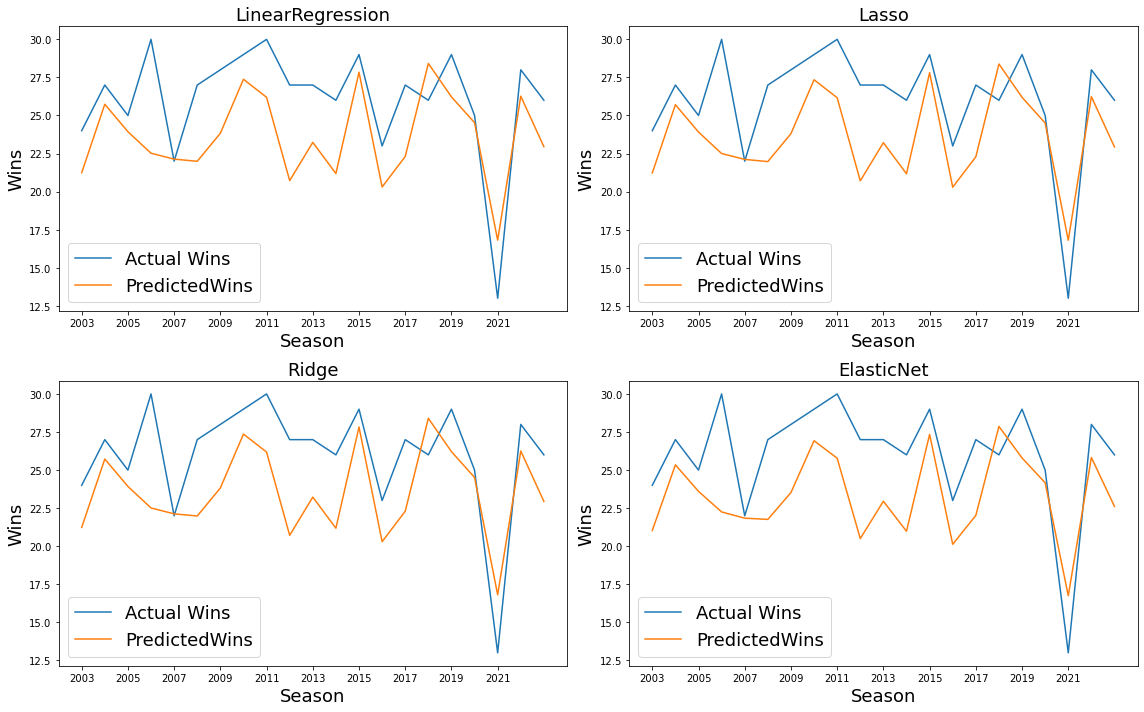

In [16]:
# Import team names data
teamNames = pd.read_csv("./data/MTeams.csv")

# Get Duke's identifying ID
teamID = teamNames.loc[teamNames["TeamName"] == "Duke", "TeamID"].item()

# Get seasons for x-axis
seasons = df["Season"].unique()

# Get Duke rat stats without score
teamRatNoScore = df.loc[df["TeamID"] == teamID, ratStatsNoScore]

# Get Duke's actual wins
actualWins = df.loc[df["TeamID"] == teamID, "GamesWon"]

# Make a matrix to store predicted wins
predictedWins = np.zeros((len(RFEModels), len(actualWins)))

# Get predicted wins for each model
for i, model in enumerate(RFEModels):
    predictedWins[i,:] = model.predict(teamRatNoScore)

# Plot these predictions
fig, axs = plt.subplots(nrows = 2,
                        ncols= 2,
                        figsize = (16, 10)
                       )

for i, (modelName, ax) in enumerate(zip(modelNames, axs.flatten())):
    ax.plot(seasons, actualWins)
    ax.plot(seasons, predictedWins[i,:])

    
    ax.set_title(modelName, size= 18)
    ax.set_xlabel("Season", size = 18)
    ax.set_ylabel("Wins", size = 18)
    ax.set_xticks(range(2003, 2023, 2))
    ax.legend(["Actual Wins", "PredictedWins"], fontsize=18)

plt.tight_layout()

plt.savefig("./plots/regressionDukeDRTO.png")
plt.show()

- It's definitely a less good estimator, but it's not too bad
- It's interesting that these two non-scoring models where chosen as the most important predictors
- Let's plot these two properties against each other and see if we can see anything

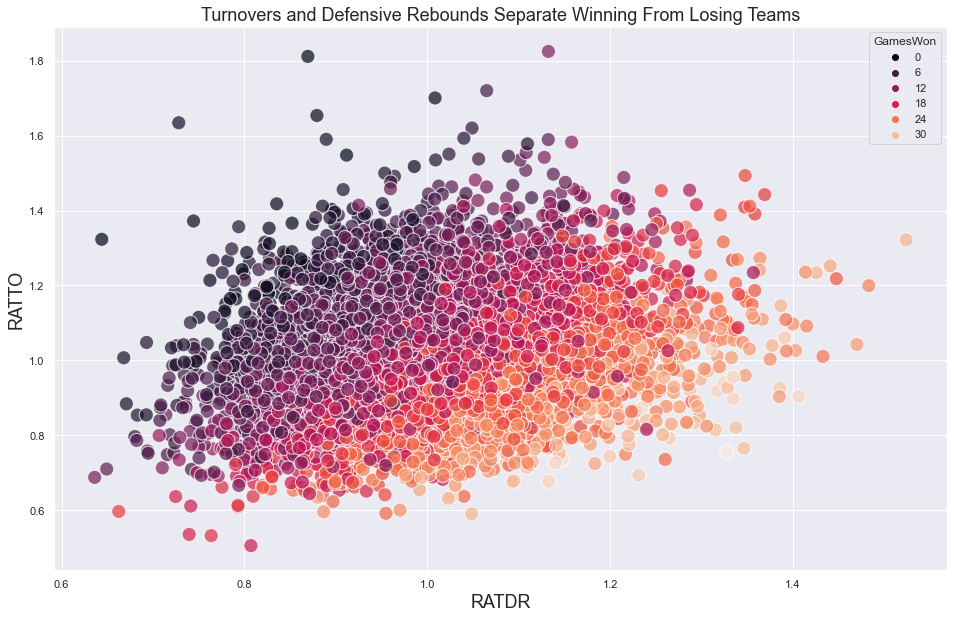

In [24]:
# Import Seaborn for plotting
import seaborn as sns

# Bin GamesWon for visualization
bins = [-1, 5, 10, 15, 20, 25, 30, 35]
df["GamesWonBinned"] = pd.cut(df["GamesWon"], bins=bins, labels=bins[1:])

sns.set(rc={'figure.figsize':(16,10)})

ax = sns.scatterplot(data=df,
                     x="RATDR",
                     y = "RATTO",
                     hue="GamesWon",
                     palette = sns.color_palette("rocket", as_cmap=True),
                     s=200,
                     alpha=0.7
                    )
sns.color_palette("rocket", as_cmap=True)

ax.set_xlabel("RATDR", size=18)
ax.set_ylabel("RATTO", size=18)

ax.set_title("Turnovers and Defensive Rebounds Separate Winning From Losing Teams", size=18)
plt.savefig("./plots/RATTORATDRWinSep.png", dpi=250)
plt.show()

- Out of curiosity, let's see if this pattern holds for march madness farthest round reached:

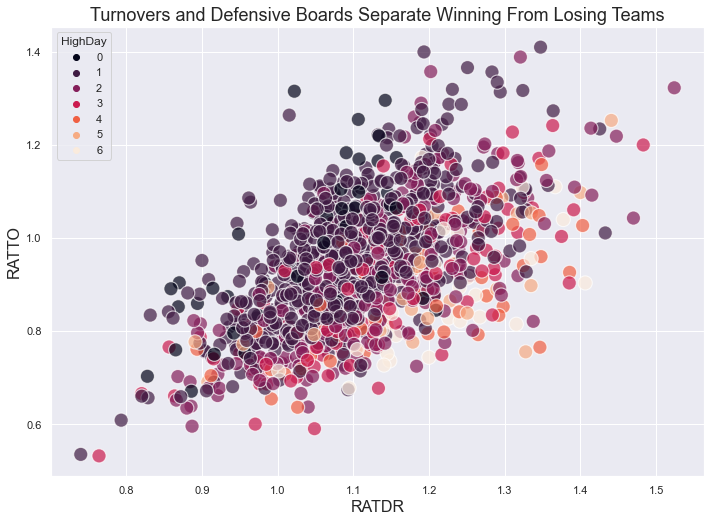

In [13]:
# Get rid of 2021 because of weird tournament scheduling
dfNo2021 = df.loc[df["Season"] != 2021]

# Get rid of teams that didn't make the tournament for more clarity
dfNo2021 = dfNo2021.loc[dfNo2021["HighDay"] > -1]

sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = sns.scatterplot(data=dfNo2021,
                     x="RATDR",
                     y = "RATTO",
                     hue="HighDay",
                     palette=sns.color_palette("rocket", as_cmap=True),
                     s=200,
                     alpha=0.7
                    )

ax.set_xlabel("RATDR", size=16)
ax.set_ylabel("RATTO", size=16)

ax.set_title("Turnovers and Defensive Boards Separate Winning From Losing Teams", size=18)

plt.show()

- There is a pattern but it's not as stark
- Now let's look at the 6 most important features:

In [14]:
# Create a list of models with RFE
RFEModels = [
    RFE(estimator=model,
                   n_features_to_select=3,
                   step=1
                  )
    for model in models
]

# Fit all of the models
for model in RFEModels:
    model.fit(seasonRatDatNoScore, seasonWinDat)

# Print out the name of selected features
for model, name in zip(RFEModels, modelNames):
    print(f"{name}: {model.get_feature_names_out()}")
importantFeatures = RFEModels[0].get_feature_names_out()

LinearRegression: ['RATFGA' 'RATDR' 'RATTO']
Lasso: ['RATFGA' 'RATDR' 'RATTO']
Ridge: ['RATFGA' 'RATDR' 'RATTO']
ElasticNet: ['RATFGM' 'RATDR' 'RATTO']


- Now we perform PCA:

In [15]:
# Import PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


x = df.loc[:, importantFeatures].values
y = df.loc[:,['HighDay']].values

x = StandardScaler().fit_transform(x)

pca = PCA(n_components= len(importantFeatures) )
principalComponents = pca.fit_transform(x)

pcas = [("pc" + str(x)) for x in np.arange(1, len(importantFeatures) + 1)]

principalDf = pd.DataFrame(data = principalComponents
             , columns = pcas)

df = df.reset_index()

principalDf["HighDay"] = df["HighDay"]
principalDf["GamesWon"] = df["GamesWonBinned"]
principalDf["TeamID"] = df["TeamID"]

print("PCA 1:")
for combo in zip(pca.components_[0], importantFeatures):
    print(f"{combo[1]:} {combo[0]}")
 
print()

print("PCA 3:")
for combo in zip(pca.components_[1], importantFeatures):
    print(f"{combo[1]:} {combo[0]}")
    

PCA 1:
RATFGA 0.6508668876031797
RATDR -0.39963923859853057
RATTO -0.645492659597409

PCA 3:
RATFGA -0.26458438385367117
RATDR -0.9163363553275752
RATTO 0.30053749803601915


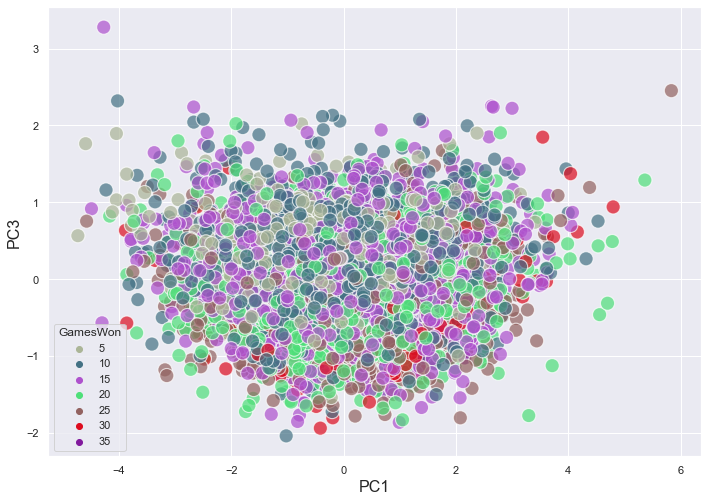

In [16]:
import random

# Bin GamesWon for visualization
bins = [-1, 5, 10, 15, 20, 25, 30, 35]
df["GamesWonBinned"] = pd.cut(df["GamesWon"], bins=bins, labels=bins[1:])

colors = []
n = len(bins) - 1
random.seed(35)
for i in range(n):
    colors.append('#%06X' % random.randint(0, 0xFFFFFF))

sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = sns.scatterplot(data=principalDf, x="pc1", y = "pc3", hue="GamesWon", palette=colors, s=200, alpha=0.7)

ax.set_xlabel("PC1", size=16)
ax.set_ylabel("PC3", size=16)

plt.show()

In [17]:
# from sklearn.ensemble import IsolationForest

# clf = IsolationForest(random_state=0).fit(seasonRatDat)
# results = clf.predict(seasonRatDat)
# np.unique(results, return_counts = True)

# # Import Seaborn for plotting
# import seaborn as sns

# df["outlier"] = results

# ax = sns.scatterplot(data=df,
#                      x="RATDR",
#                      y = "RATTO",
#                      hue="outlier",
#                      palette = sns.color_palette("rocket", as_cmap=True),
#                      s=200,
#                      alpha=0.7
#                     )
# sns.color_palette("rocket", as_cmap=True)

# ax.set_xlabel("RATDR", size=16)
# ax.set_ylabel("RATTO", size=16)

# ax.set_title("Turnovers and Defensive Boards Separate Winning From Losing Teams", size=18)

# plt.show()

In [18]:
ratings = pd.read_csv("./data/MMasseyOrdinals_thru_Season2023_Day128.csv")
ratings = ratings.loc[ratings["Season"] != 2021]
SELRatings = ratings.loc[ratings["SystemName"] == "SEL"]
DukeRatings = SELRatings.loc[SELRatings["TeamID"] == 1181]
DukeRatings = DukeRatings.reset_index()
DukeRatingsSeasons = DukeRatings[["Season", "OrdinalRank"]]
DukeRatingSeasonAverages = DukeRatingsSeasons.groupby("Season").mean()
DukeRatingSeasonAverages

OrdinalRank
Season             
2003       9.600000
2004       3.461538
2005       3.538462
2006       1.076923
2007       9.888889
2008       6.000000
2009       3.100000
2011       3.727273
2012       5.272727
2013       1.333333
2014      14.500000
2015       4.250000
2016      17.909091
2017      14.000000
2018       6.285714
2019       2.000000
2020       4.636364
2022      19.250000
2023      21.500000

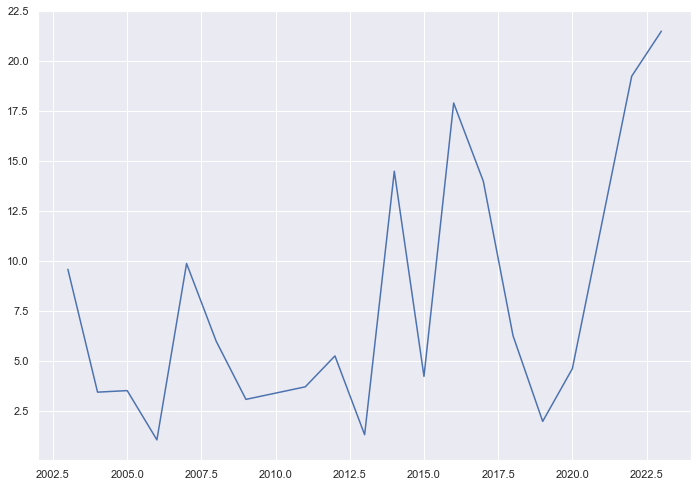

In [19]:
plt.plot(DukeRatingSeasonAverages)

In [20]:
reg = RidgeCV().fit(seasonRatDat[["RATDR", "RATTO"]], seasonWinDat)
reg.coef_

array([ 42.23336046, -25.10919857])

0.8273296488282983
0.8232473162066873
0.825395212209242
0.8196457218928562
0.8292539916006221
0.8489652517350047
0.8312675672817857
0.8542343760175469
0.8276894105422979
0.8468501909268896
0.8098994285680023
0.8140072142149448
0.8292549894793967
0.8220672439608734
0.8383961207378882
0.8252027473076626
0.8377681886476362
0.8101613597036251
0.7045059268283459
0.8066302510425393
0.7925320948783409


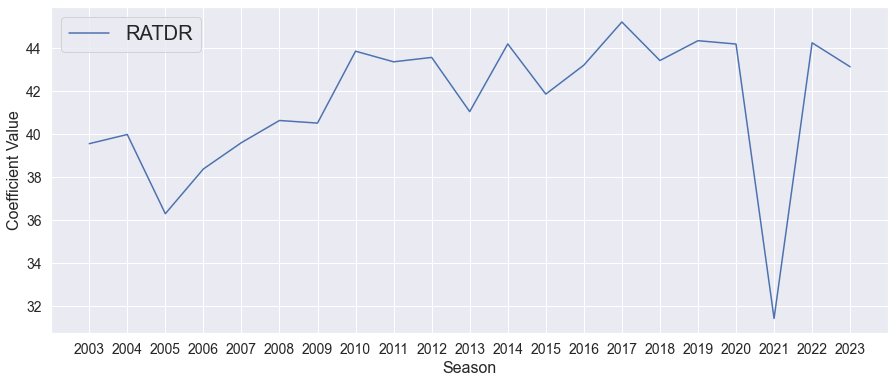

In [21]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

statsToMeasure = ["FGM", "FGA", "FGM3", "FGA3", "FTM", "FTA", "OR", "DR", "Ast", "TO", "Stl", "Blk", "PF"]
statsMeasured = ["AVG" + stat for stat in statsToMeasure]
statsMeasured = statsMeasured + ["O" + stat for stat in statsMeasured]
statsMeasured = statsMeasured + ["RAT" + stat for stat in statsToMeasure]

statsMeasured = ["RATDR", "RATTO"]

teams = df["TeamID"].unique()
seasons = df["Season"].unique()

seasons = np.arange(2003,2024)

predictedWins = np.zeros(len(seasons))
coeffs = pd.DataFrame(columns = statsMeasured)


for i, season in enumerate(seasons):
    seasonStatsMod = df.loc[df["AVGFGA3"] != 0]
    seasonStatsMod = seasonStatsMod.loc[seasonStatsMod["Season"] == season]
    seasonStatsMod = seasonStatsMod.loc[df["AVGFGA3"] != -1]
    # seasonStatsMod = seasonStatsMod.loc[seasonStatsMod["TeamID"] != 1181]
    X = seasonStatsMod[statsMeasured].to_numpy()
    #X = StandardScaler().fit_transform(X)
    y = seasonStatsMod["GamesWon"].to_numpy()
    
    reg = linear_model.RidgeCV().fit(X, y)
    
    # Duke = df.loc[df["TeamID"] == 1183]
    # Duke = Duke.loc[Duke["Season"] == season]
    # Duke = Duke[statsMeasured].to_numpy()
    # predictedWins[i] = reg.predict(Duke)
    
    coeffs.loc[len(coeffs)] = reg.coef_
    print(reg.score(X, y))
    
    


fig, ax = plt.subplots(figsize=(15, 6))



# statsToPlot = ["AVGFGM","AVGOR", "AVGFGA3", "RATFTA", "OAVGFGM" ]
statsToPlot = ["RATDR"]
ax.plot(seasons, coeffs[statsToPlot])

# ax.plot(seasons, predictedWins)
# ax.plot(seasons, actualWins)

ax.set_xticks(seasons)

#ax.set_title("Duke AVGFGA3 importance", size=20)
ax.set_xlabel("Season", size=16)
ax.set_ylabel("Coefficient Value", size=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(statsToPlot, fontsize=20)

plt.savefig("./plots/three.png",dpi=200)
plt.show()


actualWins = df.loc[df["TeamID"] == 1183, "GamesWon"]


In [22]:
ratings

Season  RankingDayNum SystemName  TeamID  OrdinalRank
0          2003             35        SEL    1102          159
1          2003             35        SEL    1103          229
2          2003             35        SEL    1104           12
3          2003             35        SEL    1105          314
4          2003             35        SEL    1106          260
...         ...            ...        ...     ...          ...
4922507    2023            128        WOL    1473          332
4922508    2023            128        WOL    1474          166
4922509    2023            128        WOL    1475          260
4922510    2023            128        WOL    1476          301
4922511    2023            128        WOL    1477          303

[4703408 rows x 5 columns]

In [23]:
X = df[["RATDR", "RATTO"]].to_numpy()
y = df[["GamesWon"]].to_numpy()
y = y.ravel()
reg = LassoCV()
reg.fit(X,y)

y_pred = reg.predict(X)

In [24]:
mean_squared_error(y, y_pred)

7.78571801842853

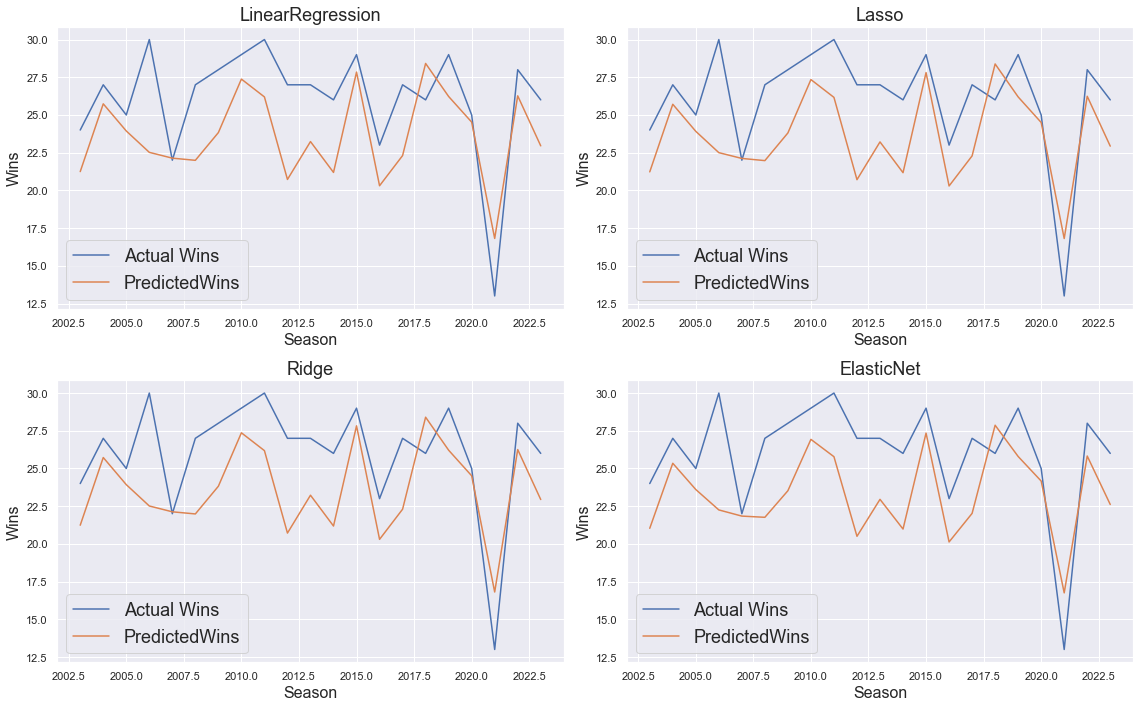

In [62]:
# Read in the average season stats data
df = pd.read_csv("./seasonStats.csv")

# Get only the entries with useful data
df = df.loc[df["AVGFGA3"] > 0.0]

# Import team names data
teamNames = pd.read_csv("./data/MTeams.csv")

# Get Duke's identifying ID
teamID = teamNames.loc[teamNames["TeamName"] == "Duke", "TeamID"].item()

# Get seasons for x-axis
seasons = df["Season"].unique()

# Get Duke rat stats without score
teamRatNoScore = df.loc[df["TeamID"] == teamID, ratStatsNoScore]

# Get Duke's actual wins
actualWins = df.loc[df["TeamID"] == teamID, "GamesWon"]

# Make a matrix to store predicted wins
predictedWins = np.zeros((len(models), len(actualWins)))

# Get predicted wins for each model
for i, model in enumerate(models):
    model.fit(seasonRatDatNoScore[["RATDR", "RATTO"]], seasonWinDat)
    predictedWins[i,:] = model.predict(teamRatNoScore[["RATDR", "RATTO"]])

# Plot these predictions
fig, axs = plt.subplots(nrows = 2,
                        ncols= 2,
                        figsize = (16, 10)
                       )

for i, (modelName, ax) in enumerate(zip(modelNames, axs.flatten())):
    ax.plot(seasons, actualWins)
    ax.plot(seasons, predictedWins[i,:])

    
    ax.set_title(modelName, size= 18)
    ax.set_xlabel("Season", size = 16)
    ax.set_ylabel("Wins", size = 16)
    ax.legend(["Actual Wins", "PredictedWins"], fontsize=18)

plt.tight_layout()
plt.show()

In [29]:
seasonWinDat

1       17
2       17
3       23
4       17
5       20
        ..
7644    15
7665    13
7686    13
7707    12
7728     8
Name: GamesWon, Length: 7255, dtype: int64

In [47]:
ratStatsNoScore[["RATTO", "RATDR"]]

TypeError: list indices must be integers or slices, not list

In [49]:
seasonRatDatNoScore

RATFGM    RATFGA   RATFGM3   RATFGA3    RATFTM    RATFTA     RATOR  \
1     1.033794  1.030245  1.000000  1.037313  1.223529  1.220833  1.245902   
2     1.069630  0.983354  0.981043  0.892562  1.121519  1.122124  0.982036   
3     1.052559  0.884163  1.065116  0.978333  1.802817  1.597254  0.887283   
4     0.984765  0.911098  0.720721  0.753600  1.590747  1.547677  1.025424   
5     1.014981  0.923077  0.930233  0.773181  1.438486  1.396963  0.981043   
...        ...       ...       ...       ...       ...       ...       ...   
7644  0.906949  0.969298  1.153191  1.169670  1.375375  1.366379  1.172996   
7665  0.902760  0.891218  0.907631  0.901389  1.126100  1.051975  0.519164   
7686  1.010652  1.058964  1.173729  1.129851  0.827869  0.875923  1.369863   
7707  0.980838  1.015109  1.216590  1.325321  0.735656  0.756637  0.923077   
7728  0.890863  0.949056  0.842520  0.819695  0.912234  0.863720  0.720000   

         RATDR    RATAst     RATTO    RATStl    RATBlk     RATPF  
1     1.056782  1.036697  0.958763  1.193548  1.191011  0.936920  
2     1.085803  1.045593  0.987179  1.289655  0.909091  0.909402  
3     1.308072  1.121622  1.091954  0.891429  2.111111  0.741611  
4     1.195286  0.910026  1.149560  0.943590  1.158730  0.746741  
5     1.205521  0.916667  1.142857  0.772321  1.314516  0.779174  
...        ...       ...       ...       ...       ...       ...  
7644  1.015299  0.956098  1.151613  0.917526  0.544000  0.921905  
7665  0.924761  0.856115  0.992248  1.000000  0.965909  0.920892  
7686  1.040462  0.954054  1.080838  1.084270  0.532258  1.007449  
7707  0.917120  1.062350  1.069892  0.868293  1.314286  1.151631  
7728  0.899729  0.743056  1.080925  0.810427  1.125000  1.057778  

[7255 rows x 13 columns]